Authors
- Shawn Fan
- Artur Dox
- Ang Li
- Holly Whitfield
- Ramon Vinas Torne

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import anndata
from metrics import *
from de import *
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from plottable import *
from plottable.cmap import *
from matplotlib.colors import LinearSegmentedColormap

In [8]:
data_file = '/Users/arturdox/Downloads/1gene-norman.h5ad'
adata = anndata.read_h5ad(data_file)
adata_control = adata[adata.obs['perturbation_name'] == 'control']
control_mean = np.array(adata_control.X.mean(axis=0))[0]

# Select subset of perturbations for testing purposes
adata_subset = adata[adata.obs['perturbation_name'].isin(['FOXA1', 'FOXA3'])]

# Simulate split (ground truth cells, predicted cells)
idxs_gt, idxs_pred = train_test_split(np.arange(len(adata_subset)), test_size=0.5)
adata_gt = adata_subset[idxs_gt]
adata_pred = adata_subset[idxs_pred]

In [9]:
# Run DE analysis
de_genes_gt = get_de_genes(adata_control, adata_gt,
                           method = "wilcoxon",
                           top_k = 100,
                           groupby_key = 'perturbation_name')
de_genes_pred = get_de_genes(adata_control, adata_pred,
                             method = "wilcoxon",
                             top_k = 100,
                             groupby_key = 'perturbation_name')

/Users/arturdox/coding/mlbiolab/scEvalsJam/metrics/de.py:41: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  anndata_x.obs["group"] = "control"
/Users/arturdox/coding/mlbiolab/scEvalsJam/metrics/de.py:42: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  anndata_y.obs["group"] = "perturbation"
/Users/arturdox/.virtualenvs/biodatasets/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/arturdox/.virtualenvs/biodatasets/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and ret

In [10]:
### --- Calculate metrics per scenario
unique_perturbations = adata_subset.obs['perturbation_name'].unique()

## Calculate metrics
results_list = [calc_metrics(adata_gt, adata_pred, adata_control,
                             pert, metric_dict, 
                             de_genes_gt, de_genes_pred, 
                             de_subset = None) for pert in tqdm(unique_perturbations)]
## Build dataframe
results_df = pd.DataFrame(results_list,
                          index=[i for i in unique_perturbations], 
                          columns=list(metric_dict.keys())+["Jaccard_de_up", "Jaccard_de_dn"])

## Remove redundant metrics
redundant_column_mask = results_df.columns.str.contains('ec') & results_df.columns.str.contains('mse|mae|euclidean_distance|bhattacharyya_distance')
results_df = results_df.loc[:, ~redundant_column_mask]

  0%|          | 0/2 [00:00<?, ?it/s]/Users/arturdox/coding/mlbiolab/scEvalsJam/metrics/metrics.py:65: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - np.mean(intersection / union)
/Users/arturdox/.virtualenvs/biodatasets/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
 50%|█████     | 1/2 [00:08<00:08,  8.68s/it]/Users/arturdox/coding/mlbiolab/scEvalsJam/metrics/metrics.py:65: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - np.mean(intersection / union)
/Users/arturdox/.virtualenvs/biodatasets/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
100%|██████████| 2/2 [00:1

In [11]:
results_df

,mse,mae,ks_test_distance,edistance,cosine_distance,pearson_distance,euclidean_distance,classifier_proba,kendalltau_distance,spearman_distance,wasserstein,sym_kldiv,bhattacharyya_distance,jaccard_index,F1_score,adjusted_rand_index,mutual_information,fowlkes_mallows_index,Jaccard_de_up,Jaccard_de_dn
FOXA1,0.000425,0.011849,0.015664,16.156790,0.066612,0.081609,2.842252,0.465336,4.200920e+07,0.305569,2584.142152,9.171504e+11,0.000065,NaN,0.0,0.0,0.973585,0.189368,0.428571,0.438849
FOXA3,0.000513,0.013640,0.019233,19.494399,0.063683,0.075890,3.122051,0.399688,4.466904e+07,0.348729,2599.199181,1.537109e+12,0.000091,NaN,0.0,0.0,0.976292,0.191670,0.388889,0.492537


In [186]:
results_df

,mse,mae,ks_test_distance,edistance,cosine_distance,pearson_distance,euclidean_distance,classifier_proba,kendalltau_distance,spearman_distance,wasserstein,sym_kldiv,bhattacharyya_distance,jaccard_index,F1_score,adjusted_rand_index,mutual_information,fowlkes_mallows_index,Jaccard_de_up,Jaccard_de_dn
FOXA1,0.000425,0.011849,0.015664,16.156790,0.066612,0.081609,2.842252,0.474217,4.200920e+07,0.305569,2584.142152,9.171504e+11,0.000065,NaN,0.0,0.0,0.973585,0.189368,0.428571,0.438849
FOXA3,0.000513,0.013640,0.019233,19.494399,0.063683,0.075890,3.122051,0.379076,4.466904e+07,0.348729,2599.199181,1.537109e+12,0.000091,NaN,0.0,0.0,0.976292,0.191670,0.388889,0.492537


## Plotting

In [210]:
def plot_metrics(data: pd.DataFrame, genes: list, metrics: list):
    perturbations = data.index.to_list()
    data['perturbations'] = perturbations
    data.reset_index(drop=True, inplace=True)
    
    def truncate_decimals(x):
        return float(f"{x:.3f}")
    
    metrics_columns = data.select_dtypes(include=['float64','float32']).columns
    data_selected_genes = data[data['perturbations'].isin(genes)]
    data_selected_genes.drop(['perturbations'],axis=1,inplace=True)
    
    # Average over type of perturbations
    if len(genes) > 1:
        data_selected_genes = data_selected_genes.groupby('methods').mean()
    else:
        data_selected_genes.set_index('methods',inplace=True)
    
    # Truncate all numeric values to three decimals    
    data_selected_genes[metrics_columns] = data_selected_genes[metrics_columns].applymap(truncate_decimals)

    cmap_name = matplotlib.cm.PiYG
    col_defs = ([
        ColumnDefinition(
            name="methods",
            textprops={"ha": "left", "weight": "bold"},
            width=1.5,
        )])
    for metric in metrics:
        col_defs.append(ColumnDefinition(
            name=metric,
            width=0.75,
            textprops={
                "ha": "center",
                "bbox": {"boxstyle": "circle", "pad": 0.35},
            },
            cmap=normed_cmap(data_selected_genes[metric], cmap=cmap_name, num_stds=2)
        ))
    fig, ax = plt.subplots(figsize=(16, 8))
    table = Table(
        data_selected_genes[metrics],
        column_definitions=col_defs,
        row_dividers=True,
        footer_divider=True,
        ax=ax,
        textprops={"fontsize": 14},
        row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
        col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
        column_border_kw={"linewidth": 1, "linestyle": "-"},
    ).autoset_fontcolors(colnames=metrics)

### Simulated Example

In [33]:
shuffeled_adata_list = []
for i in range(4):
    shuffeled_adata = adata_pred.copy()
    np.random.shuffle(shuffeled_adata.X.toarray())
    shuffeled_adata_list.append(shuffeled_adata)

In [34]:
results_df_list = []
for shuffeled_adata in shuffeled_adata_list:
    # Run DE analysis
    de_genes_gt = get_de_genes(adata_control, adata_gt,
                            method = "wilcoxon",
                            top_k = 100,
                            groupby_key = 'perturbation_name')
    de_genes_pred = get_de_genes(adata_control, adata_pred,
                                method = "wilcoxon",
                                top_k = 100,
                                groupby_key = 'perturbation_name')
    
    ### --- Calculate metrics per scenario
    unique_perturbations = adata_subset.obs['perturbation_name'].unique()

    ## Calculate metrics
    results_list = [calc_metrics(adata_gt, adata_pred, adata_control,
                                pert, metric_dict, 
                                de_genes_gt, de_genes_pred, 
                                de_subset = None) for pert in tqdm(unique_perturbations)]
    ## Build dataframe
    results_df = pd.DataFrame(results_list,
                            index=[i for i in unique_perturbations], 
                            columns=list(metric_dict.keys())+["Jaccard_de_up", "Jaccard_de_dn"])

    ## Remove redundant metrics
    redundant_column_mask = results_df.columns.str.contains('ec') & results_df.columns.str.contains('mse|mae|euclidean_distance|bhattacharyya_distance')
    results_df = results_df.loc[:, ~redundant_column_mask]
    results_df_list.append(results_df)
    
results_shuffeled = pd.concat(results_df_list)

/Users/arturdox/.virtualenvs/biodatasets/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/arturdox/.virtualenvs/biodatasets/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/arturdox/.virtualenvs/biodatasets/lib/python3.12/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify fu

/var/folders/23/mnhj1ks52b10tsp6vhvg9b540000gn/T/ipykernel_29859/3626832645.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected_genes.drop(['perturbations'],axis=1,inplace=True)
/var/folders/23/mnhj1ks52b10tsp6vhvg9b540000gn/T/ipykernel_29859/3626832645.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_selected_genes[metrics_columns] = data_selected_genes[metrics_columns].applymap(truncate_decimals)
/var/folders/23/mnhj1ks52b10tsp6vhvg9b540000gn/T/ipykernel_29859/3626832645.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

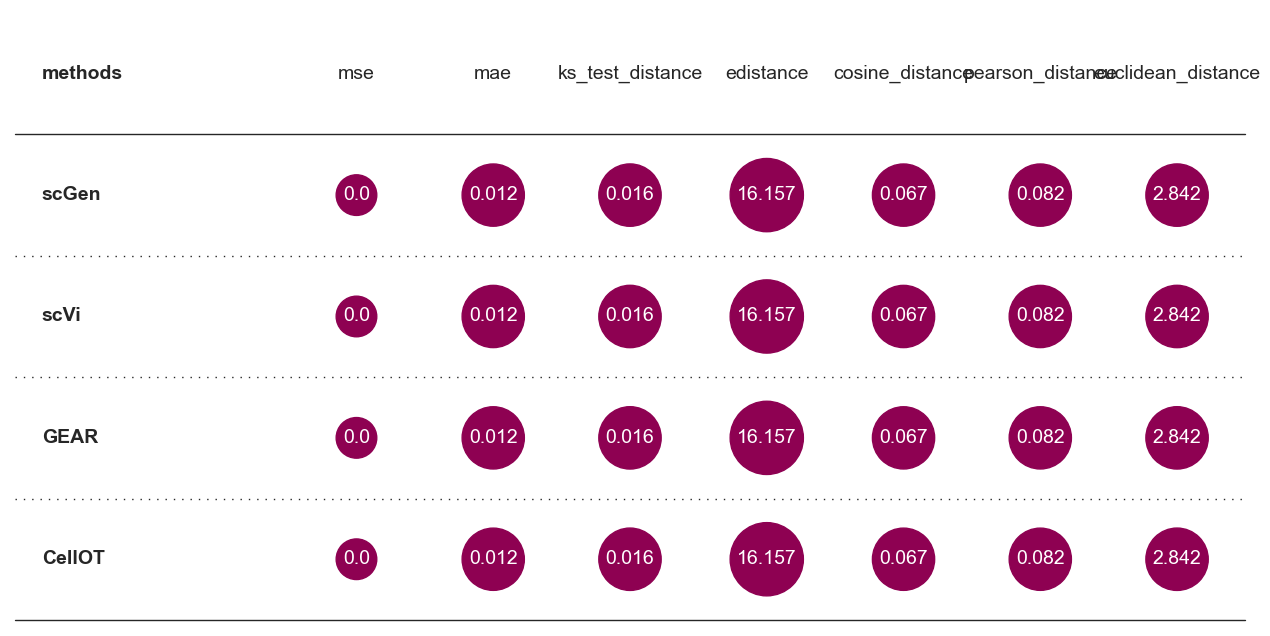

In [212]:
results = results_shuffeled.copy()
results['methods'] = ['scGen','scGen','scVi','scVi','GEAR','GEARS','CellOT','CellOT']
plot_metrics(results,['FOXA1'],['mse','mae','ks_test_distance','edistance','cosine_distance','pearson_distance','euclidean_distance'])

/var/folders/23/mnhj1ks52b10tsp6vhvg9b540000gn/T/ipykernel_29859/3626832645.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_selected_genes[metrics_columns] = data_selected_genes[metrics_columns].applymap(truncate_decimals)


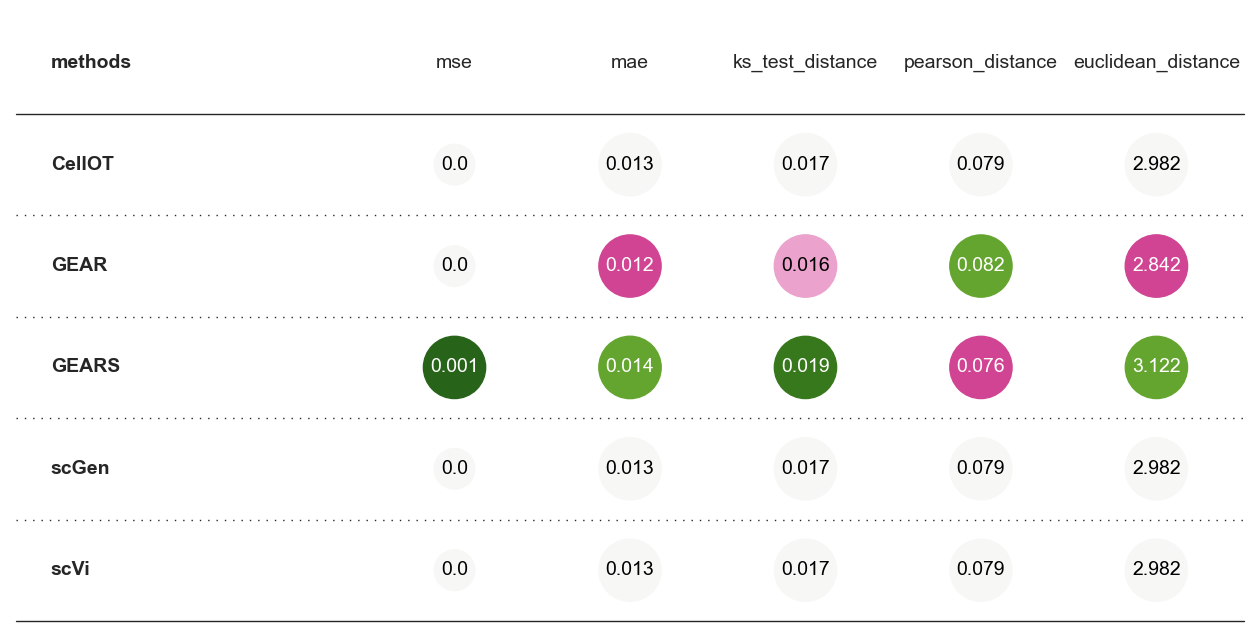

In [213]:
results = results_shuffeled.copy()
results['methods'] = ['scGen','scGen','scVi','scVi','GEAR','GEARS','CellOT','CellOT']
plot_metrics(results,['FOXA1','FOXA3'],['mse','mae','ks_test_distance','pearson_distance','euclidean_distance'])

In [185]:
results

,mse,mae,ks_test_distance,edistance,cosine_distance,pearson_distance,euclidean_distance,classifier_proba,kendalltau_distance,spearman_distance,...,bhattacharyya_distance,jaccard_index,F1_score,adjusted_rand_index,mutual_information,fowlkes_mallows_index,Jaccard_de_up,Jaccard_de_dn,methods,perturbations
0,0.000425,0.011849,0.015664,16.156790,0.066612,0.081609,2.842252,0.421169,4.200920e+07,0.305569,...,0.000065,NaN,0.0,0.0,0.973585,0.189368,0.428571,0.438849,scGen,FOXA1
1,0.000513,0.013640,0.019233,19.494399,0.063683,0.075890,3.122051,0.351833,4.466904e+07,0.348729,...,0.000091,NaN,0.0,0.0,0.976292,0.191670,0.388889,0.492537,scGen,FOXA3
2,0.000425,0.011849,0.015664,16.156790,0.066612,0.081609,2.842252,0.387422,4.200920e+07,0.305569,...,0.000065,NaN,0.0,0.0,0.973585,0.189368,0.428571,0.438849,scVi,FOXA1
3,0.000513,0.013640,0.019233,19.494399,0.063683,0.075890,3.122051,0.361086,4.466904e+07,0.348729,...,0.000091,NaN,0.0,0.0,0.976292,0.191670,0.388889,0.492537,scVi,FOXA3
4,0.000425,0.011849,0.015664,16.156790,0.066612,0.081609,2.842252,0.433395,4.200920e+07,0.305569,...,0.000065,NaN,0.0,0.0,0.973585,0.189368,0.428571,0.438849,GEAR,FOXA1
5,0.000513,0.013640,0.019233,19.494399,0.063683,0.075890,3.122051,0.282420,4.466904e+07,0.348729,...,0.000091,NaN,0.0,0.0,0.976292,0.191670,0.388889,0.492537,GEARS,FOXA3
6,0.000425,0.011849,0.015664,16.156790,0.066612,0.081609,2.842252,0.474217,4.200920e+07,0.305569,...,0.000065,NaN,0.0,0.0,0.973585,0.189368,0.428571,0.438849,CellOT,FOXA1
7,0.000513,0.013640,0.019233,19.494399,0.063683,0.075890,3.122051,0.379076,4.466904e+07,0.348729,...,0.000091,NaN,0.0,0.0,0.976292,0.191670,0.388889,0.492537,CellOT,FOXA3
